<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Line-intersection" data-toc-modified-id="Line-intersection-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Line intersection</a></span></li><li><span><a href="#Benchmark---putting-stuff-on-the-GPU" data-toc-modified-id="Benchmark---putting-stuff-on-the-GPU-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Benchmark - putting stuff on the GPU</a></span></li><li><span><a href="#Version-1---Parallelizing-both-segments-and-angles" data-toc-modified-id="Version-1---Parallelizing-both-segments-and-angles-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Version 1 - Parallelizing both segments and angles</a></span><ul class="toc-item"><li><span><a href="#CPU" data-toc-modified-id="CPU-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>CPU</a></span></li><li><span><a href="#GPU-/-CUDA-kernel" data-toc-modified-id="GPU-/-CUDA-kernel-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>GPU / CUDA kernel</a></span></li></ul></li><li><span><a href="#Version-1b---Parallelizing-segments,-angles,-and-poses" data-toc-modified-id="Version-1b---Parallelizing-segments,-angles,-and-poses-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Version 1b - Parallelizing segments, angles, and poses</a></span></li><li><span><a href="#Version-2---Parallelizing-segments-only" data-toc-modified-id="Version-2---Parallelizing-segments-only-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Version 2 - Parallelizing segments only</a></span><ul class="toc-item"><li><span><a href="#CPU" data-toc-modified-id="CPU-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>CPU</a></span></li><li><span><a href="#GPU-/-CUDA-kernel" data-toc-modified-id="GPU-/-CUDA-kernel-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>GPU / CUDA kernel</a></span></li></ul></li><li><span><a href="#Version-3---Parallelizing-segments-and-poses" data-toc-modified-id="Version-3---Parallelizing-segments-and-poses-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Version 3 - Parallelizing segments and poses</a></span></li><li><span><a href="#Version-4---avoiding-array-access-conflicts" data-toc-modified-id="Version-4---avoiding-array-access-conflicts-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Version 4 - avoiding array access conflicts</a></span><ul class="toc-item"><li><span><a href="#Examples" data-toc-modified-id="Examples-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Examples</a></span></li></ul></li><li><span><a href="#Examples" data-toc-modified-id="Examples-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Examples</a></span></li><li><span><a href="#Gen---sensor-model" data-toc-modified-id="Gen---sensor-model-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Gen - sensor model</a></span></li></ul></div>

# CUDA 2D Raycaster for Line Maps

In [2]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [3]:
#nbx --fname="src/cuda_raycaster_line_map.jl"
push!(LOAD_PATH, "src");
using MyUtils
using CUDA
using BenchmarkTools
using Colors, Plots
col = palette(:default);
import Base: @doc

In [4]:
#nbx
"""
    griddims = cuda_grid(datadims::Tuple{Vararg{Int}}, 
                         blockdims::Tuple{Vararg{Int}})

Given data dimensions `datadims` and number of threads 
in each dimension `blockdims` returns the respective 
grid dimensions `griddims` such that

    griddims[i] = ceil(Int, datadims[i]/blockdims[i])

"""
function cuda_grid(datadims::Tuple{Vararg{Int}}, blockdims::Tuple{Vararg{Int}})
    griddims = ceil.(Int, datadims./blockdims)
    return griddims
end

cuda_grid

## Line intersection

Compute the intersection of two lines by solving: $x + s \cdot dx = y + t \cdot dy$.

Implementation from my `Geometry.jl` package:

```julia
function line_intersect(x, x′, y, y′)
    dx = x′ - x
    dy = y′ - y
    v  = x - y
    if det([-dx dy]) == 0
        return [Inf;Inf]
    end
    s, t = inv([-dx dy])*v
    return s,t
end;
```

And here's a version without arrays that we can use within a cuda kernel later.

In [5]:
#nbx
function line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
    dx1, dx2 = x1′ - x1, x2′ - x2
    dy1, dy2 = y1′ - y1, y2′ - y2
    
    v1 = (x1 - y1)
    v2 = (x2 - y2)
    
    a, b = -dx1, dy1
    c, d = -dx2, dy2
    
    det = a*d - c*b
    
    if det == 0
        return Inf,Inf
    end
    
    s = 1/det*(  d*v1 - b*v2)
    t = 1/det*(- c*v1 + a*v2)

    return s,t
end;

## Benchmark - putting stuff on the GPU

In [6]:
function bench_cuarray(x,y,z)
    x_  = CuArray(x)
    y_  = CuArray(y)
    z_  = CuArray(z)
end

n = 1_000
m = 1_000
x = rand(n,2)
y = rand(m,4)
z = rand(n,4)

bs = []
for e=1:6
    n = 10^e
    x = rand(n,2)
    y = rand(n,2);
    z = rand(n,2);
    b = @benchmark bench_cuarray($x,$y,$z) samples=3 evals=3;
    push!(bs, b)
end

mean.(bs)

6-element Vector{BenchmarkTools.TrialEstimate}:
 50.668 μs
 34.846 μs
 45.493 μs
 130.141 μs
 741.899 μs
 5.633 ms

```julia
10   >> 33.175 μs
10^2 >> 32.889 μs
10^3 >> 36.669 μs
10^4 >> 134.479 μs
10^5 >> 753.159 μs
10^6 >> 6.102 ms
```

## Version 1 - Parallelizing both segments and angles

### CPU

In [26]:
#bnx
"""
    cast_cpu!(X, A, p, Z)

Given a matrix of stacked segments `X`, a vector of angles `A`, a pose `p` encoded as a 3-tuple,
fills the vector `Z` with depth/range measurements.

Todo: 
 - could speed up by either classic raytracing trick, or
 - for each segment compute the angles it covers, and 
   compute intersections for those only

"""
function cast_cpu!(X, A, p, Z)    
    
    for i = 1:size(X,1), j = 1:size(A,1)
        
        x1 , x2  = X[i,1], X[i,2]
        x1′, x2′ = X[i,3], X[i,4]
        y1 , y2  = p[1], p[2]
        y1′, y2′ = p[1] + cos(A[j]+p[3]), p[2] + sin(A[j]+p[3])
        s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
        if t >= 0 && 0 <= s <= 1
                @inbounds Z[j] = min(t, Z[j])
        end
    end
    return
end

function bench_cast_cpu!(X,A,p,Y)
    cast_cpu!(X,A,p,Y)
end

bench_cast_cpu! (generic function with 1 method)

### GPU / CUDA kernel

In [31]:
#nbx
"""
    cast!(X, A, p, Z)

Given a matrix of stacked segments `X`, a vector of angles `A`, a pose `p` encoded as a 3-tuple,
fills the vector `Z` with depth/range measurements.

Example:

```
x = rand(1_000, 4)
a = range(0, 2π, 100)
z = Inf*ones(length(a))
p = zeros(3)

x_ = CuArray(x)
a_ = CuArray(a)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(a_,1)

blockdims = (16, 16)
griddims = cuda_grid((n,m), blockdims)
CUDA.@sync begin
    @cuda threads=blockdims blocks=griddims cast!(x_, a_, p_, z_)
end
```

Todo: 
 - could speed up by either classic raytracing trick, or
 - for each segment compute the angles it covers, and 
   compute intersections for those only

"""
function cast!(X, A, p, Z)
    
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    
    for i = ix:sx:size(X,1), j = iy:sy:size(A,1)
        x1 , x2  = X[i,1], X[i,2]
        x1′, x2′ = X[i,3], X[i,4]
        y1 , y2  = p[1], p[2]
        y1′, y2′ = p[1] + cos(A[j]+p[3]), p[2] + sin(A[j]+p[3])
        s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
        if t >= 0 && 0 <= s <= 1
                @inbounds Z[j] = min(t, Z[j])
        end
    end
    
    return
end

function bench_cast!(X, A, p, Z; blockdims)
    n = size(X,1)
    m = size(A,1)

    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast!(X, A, p, Z)
    end
end

bench_cast! (generic function with 1 method)

In [34]:
n     = 1_000
num_a = 361

x = (2*rand(n,4).-1.0)
a = range(0, 2π, num_a)
z = ones(size(a,1))
p = zeros(3)

println("`cast!` GPU vs CPU")
println("x: $(size(x)), a: $(size(a))\n")

x_ = CuArray(x)
a_ = CuArray(a)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_, 1)
m = size(a_, 1)
    
blockdims = (32,8)
griddims = cuda_grid((n,m), blockdims)
CUDA.@sync begin
    @cuda threads=blockdims blocks=griddims cast!(x_,a_,p_,z_)
end
@btime bench_cast!($x_,$a_,$p_,$z_; blockdims=blockdims) samples=3 evals=3;
@btime bench_cast_cpu!($x,$a,$p,$z) samples=3 evals=3;

`cast!` GPU vs CPU
x: (1000, 4), a: (361,)

  43.078 μs (28 allocations: 1.53 KiB)
  11.771 ms (0 allocations: 0 bytes)


```julia
`cast!` GPU vs CPU
x: (1000, 4), a: (361,)

  46.306 μs (24 allocations: 1.41 KiB)
  11.820 ms (0 allocations: 0 bytes)
```

## Version 1b - Parallelizing segments, angles, and poses

In [229]:
#nbx
"""
"""
function cast′!(X, A, P, Z)
    
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
    
    for i = ix:sx:size(X,1), j = iy:sy:size(A,1), k = iz:sz:size(P,1)
        x1 , x2  = X[i,1], X[i,2]
        x1′, x2′ = X[i,3], X[i,4]
        y1 , y2  = P[k,1], P[k,2]
        y1′, y2′ = P[k,1] + cos(A[j]+P[k,3]), P[k,2] + sin(A[j]+P[k,3])
        s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
        if t >= 0 && 0 <= s <= 1
                @inbounds Z[k,j] = min(t, Z[k,j])
        end
    end
    
    return
end

function bench_cast′!(X, A, P, Z; blockdims=(16,8,2))
    n = size(X,1)
    m = size(A,1)
    k = size(P,1)


    griddims = cuda_grid((n,m,k), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast′!(X, A, P, Z)
    end
end

bench_cast′! (generic function with 1 method)

In [232]:
n = 500
m = 500
num_a = 361

x = (2*rand(n,4).-1.0)
a = range(0, 2π, num_a)
p = zeros(m, 3)
z = ones(size(p,1), size(a,1))

println("`cast!` GPU vs CPU")
println("x: $(size(x)), a: $(size(a)), p: $(size(p)) \n")

x_ = CuArray(x)
a_ = CuArray(a)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_, 1)
m = size(a_, 1)
k = size(p_, 1)
    

datadims = (n,m,k)
blockdims = (16, 4, 4)
griddims = cuda_grid(datadims, blockdims)
println("data: $(datadims), block: $(blockdims), grid: $(griddims)")
CUDA.@sync begin
    @cuda threads=blockdims blocks=griddims cast′!(x_,a_,p_,z_)
end
@btime bench_cast′!($x_,$a_,$p_,$z_; blockdims=blockdims) samples=3 evals=3;

`cast!` GPU vs CPU
x: (500, 4), a: (361,), p: (500, 3) 

data: (500, 361, 500), block: (16, 4, 4), grid: (32, 91, 125)
  6.429 ms (76 allocations: 4.56 KiB)


```julia
`cast!` GPU vs CPU
x: (500, 4), a: (361,), p: (500, 3) 

data: (500, 361, 500), block: (8, 4, 8), grid: (63, 91, 63)
  7.476 ms (76 allocations: 4.56 KiB)
```

## Version 2 - Parallelizing segments only

In [22]:
using LinearAlgebra: dot

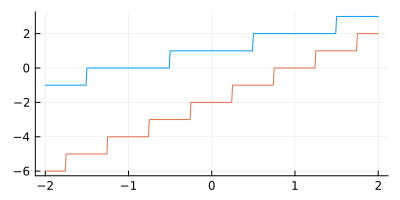

In [23]:
quantize(x, r; zero=0) = Int(floor((x + r/2 - zero)/r))
xs  = -2:0.01:2
# ----------------- 
plot(size=(400,200))
plot!(xs, quantize.(xs, 1.0; zero=-1), legend=nothing)
plot!(xs, quantize.(xs, 0.5; zero= 1), legend=nothing)

### CPU

In [24]:
#nbx
"""
    cast_v2_cpu!(X, p, Z)

Given a matrix of stacked segments `X`, a pose `p` encoded as a 3-tuple,
fills the vector `Z` with depth/range measurements.
"""
function cast_v2_cpu!(X, p, Z)
    
    fov = 2π
    num_a = size(Z,1)
    r = a_res  = fov/num_a
    
    
    for i = 1:size(X,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - p[1], X[i,2] - p[2]
        x1′, x2′ = X[i,3] - p[1], X[i,4] - p[2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - p[3] 
        a2 = atan(x2′, x1′) - p[3]
        
        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            a1, a2 = a2 - 2π, a1
        end

        # Get the start end end bin
        zero = 0
        k1 = Int(floor((a1 + r/2 - zero)/r))+1
        k2 = Int(floor((a2 + r/2 - zero)/r))+1
        a1 = k1*a_res
        a2 = k2*a_res
        

        for k = k1:k2
            a = (k-1)*a_res + p[3] 
            y1′, y2′ = cos(a), sin(a)
            
            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if t > 0 && 0 <= s <= 1
                k = mod(k-1,num_a)+1
                @inbounds Z[k] = min(t, Z[k])
            end
        end
        
    end
    return
end

cast_v2_cpu!

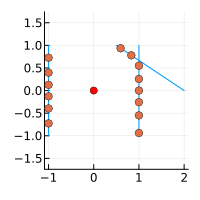

In [25]:
X = stack([
    [1,1,1,-1],
    [-1,1,-1,-1],
    [0.5,1.,2,0]
])

num_a = 25
a     = collect(range(0,2π, num_a+1)[1:end-1])
p     = [0,0,0]
Z     = Inf*ones(num_a)

cast_v2_cpu!(X, p, Z)
y = polar_inv(Z,a)

# -------------------
plot(size=(200,200), legend=nothing, aspect_ratio=:equal)
for x in eachrow(X)
    plot!(x[[1,3]],x[[2,4]], c=col[1])
end
scatter!([p[1]],[p[2]], c=:red)
scatter!(y, c=col[2], marker=:o)

### GPU / CUDA kernel

In [22]:
#nbx
"""
    cast_v2!(X, p, Z)

Given a matrix of stacked segments `X`, a pose `p` encoded as a 3-tuple,
fills the vector `Z` with depth/range measurements.
Example:

```
x = rand(1_000, 4)
z = Inf*ones(360)
p = [0.5,0.5,0]

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
blockdims = (256,)
griddims = cuda_grid((n,), blockdims)
@cuda threads=blockdims blocks=griddims cast_v2!(x_,p_,z_)

```
"""
function cast_v2!(X, p, Z)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    sx = gridDim().x * blockDim().x
    
    fov = 2π
    num_a = size(Z,1)
    r = a_res  = fov/num_a
    for i = ix:sx:size(X,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - p[1], X[i,2] - p[2]
        x1′, x2′ = X[i,3] - p[1], X[i,4] - p[2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - p[3] 
        a2 = atan(x2′, x1′) - p[3]
        
        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            a1, a2 = a2 - 2π, a1
        end

        # Get the start end end bin
        zero = 0
        k1 = Int(floor((a1 + r/2 - zero)/r))+1
        k2 = Int(floor((a2 + r/2 - zero)/r))+1
        a1 = k1*a_res
        a2 = k2*a_res
        

        for k = k1:k2
            a = (k-1)*a_res + p[3] 
            y1′, y2′ = cos(a), sin(a)
            
            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if t > 0 && 0 <= s <= 1
                k = mod(k-1,num_a)+1
                @inbounds Z[k] = min(t, Z[k])
            end
        end
        
    end
    return
end

function bench_cast_v2!(X, p, Z)
    n = size(X,1)
    
    blockdims = (256,)
    griddims = cuda_grid((n,), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast_v2!(X, p, Z)
    end
end

bench_cast_v2! (generic function with 1 method)

In [25]:
n  = 1_000
na = 361 
x = (2*rand(n,4).-1.0)
a = range(0, 2π, na)
z = ones(length(a))
p = zeros(3)
    
println("`cast_v2!` GPU vs CPU")
println("x: $(size(x)), a: $(size(a))\n")

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
blockdims = (256,)
griddims = cuda_grid((n,), blockdims)
@cuda threads=blockdims blocks=griddims cast_v2!(x_,p_,z_)
@btime bench_cast_v2!($x_,$p_,$z_) samples=3 evals=3;
@btime cast_v2_cpu!($x,$p,$z) samples=3 evals=3;

`cast_v2!` GPU vs CPU
x: (1000, 4), a: (361,)

  231.418 μs (22 allocations: 1.16 KiB)
  3.343 ms (0 allocations: 0 bytes)


```julia
 232.197 μs (22 allocations: 1.16 KiB)
   3.431 ms (0 allocations: 0 bytes)
```

## Version 3 - Parallelizing segments and poses

In [243]:
#nbx
"""
    cast_v3!(X, P, Z)

Caution: Implicitly assumes a fov of 2π!

Given an array of stacked segments `X`, an array of stacked poses `P` each encoded as a 3-Vector,
fills the Array `Z` with depth/range measurements.

Example:

```julia
x = rand(1_000, 4)
p = rand(  500, 3)
z = Inf*ones(size(p,1), 360)

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims  = (n,m)
blockdims = (16,16)
griddims = cuda_grid(datadims, blockdims)
@cuda threads=blockdims blocks=griddims cast_v3!(x_,p_,z_)
```

Runtimes:

```julia
`cast_v3!` GPU vs CPU
x: (500, 4), a: (361,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.252 ms (74 allocations: 4.33 KiB)


`cast_v3!` GPU vs CPU
x: (1000, 4), a: (361,), p: (1, 3)
data: (1000, 1), block: (256, 1), grid: (4, 1)
>>  17.535 μs (26 allocations: 1.39 KiB)
```

"""
function cast_v3!(X, P, Z)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    
    fov = 2π
    num_a = size(Z,2)
    r = fov/num_a
    
    for i = ix:sx:size(X,1), j = iy:sy:size(P,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - P[j,1], X[i,2] - P[j,2]
        x1′, x2′ = X[i,3] - P[j,1], X[i,4] - P[j,2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - P[j,3]
        a2 = atan(x2′, x1′) - P[j,3]

        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            a1, a2 = a2 - 2π, a1
        end

        # Get the start end end bin
        zero = - π;
        k1 = Int(floor((a1 + r/2 - zero)/r))+1
        k2 = Int(floor((a2 + r/2 - zero)/r))+1
        
        for k = k1:k2
            a = zero + (k-1)*r + P[j,3] 
            y1′, y2′ = cos(a), sin(a)
            
            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if 0 < t && 0 <= s <= 1
                k = mod(k-1,num_a)+1
                @inbounds Z[j,k] = min(t, Z[j,k])
            end
        end
        
    end
    return
end

function bench_cast_v3!(X, P, Z; blockdims=(16,16))
    n = size(X,1)
    m = size(P,1)
    
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast_v3!(X, P, Z)
    end
end

bench_cast_v3! (generic function with 1 method)

In [234]:
n = 500
m = 500
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)
z = ones(m, 360)
    
println("`cast_v3!` GPU vs CPU")
println("x: $(size(x)), a: $(size(a)), p: $(size(p))")

x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims = (n,m)
blockdims = (16,16)
griddims = cuda_grid(datadims, blockdims)
println("data: $(datadims), block: $(blockdims), grid: $(griddims)")
@cuda threads=blockdims blocks=griddims cast_v3!(x_,p_,z_)
@btime bench_cast_v3!($x_,$p_,$z_; blockdims=$blockdims) samples=3 evals=3;

`cast_v3!` GPU vs CPU
x: (500, 4), a: (361,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
  1.604 ms (71 allocations: 4.23 KiB)


```julia
`cast_v3!` GPU vs CPU
x: (500, 4), a: (361,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.252 ms (74 allocations: 4.33 KiB)


`cast_v3!` GPU vs CPU
x: (1000, 4), a: (360,), p: (1, 3)
data: (1000, 1), block: (256, 1), grid: (4, 1)
>>  231.091 μs (23 allocations: 1.30 KiB)
```

## Version 4 - avoiding array access conflicts

In [9]:
#nbx
@doc raw"""
    fill_z!(X, P, Z)

Caution: Implicitly assumes a fov of 2π!

Given an array of stacked segments `X`, an array of stacked poses `P` each encoded as a 3-Vector,
fills the Array `Z` with depth/range measurements.
"""
function fill_z!(X, P, Z)
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    
    fov = 2π
    num_a = size(Z,3)
    r = fov/num_a
    
    for i = ix:sx:size(X,1), j = iy:sy:size(P,1)
        
        # convert everything into pose coords
        x1 , x2  = X[i,1] - P[j,1], X[i,2] - P[j,2]
        x1′, x2′ = X[i,3] - P[j,1], X[i,4] - P[j,2]
        dx1, dx2 = x1′-x1, x2′-x2
        y1 , y2  = 0, 0
        a1 = atan(x2 , x1 ) - P[j,3]
        a2 = atan(x2′, x1′) - P[j,3]

        # Ensure a1 < a2
        if a1 > a2
            a1, a2 = a2, a1
        end
        
        # Check if we cross from `-π+a` to `π-b`
        if a2 - a1 > π
            a1, a2 = a2 - 2π, a1
        end

        # Get the start end end bin
        zero = - π;
        k1 = Int(floor((a1 + r/2 - zero)/r))+1
        k2 = Int(floor((a2 + r/2 - zero)/r))+1
        
        for k = k1:k2
            a = zero + (k-1)*r + P[j,3] 
            y1′, y2′ = cos(a), sin(a)
            
            s, t = line_intersection(x1, x2, x1′, x2′, y1, y2, y1′, y2′)
            if 0 < t && 0 <= s <= 1
                k = mod(k-1,num_a)+1
                @inbounds Z[j, i, k] = t
            end
        end
        
    end
    return
end


function bench_fill_z!(X, P, Z; blockdims=(16,16))
    n = size(X,1)
    m = size(P,1)
    
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims fill_z!(X, P, Z)
    end
end;


@doc raw"""
    cast_v4!(X, P, Z; blockdims=(16,16))

Takes array of `n` stacked segments `X` and `m` stacked poses `P`
and an observation array `Z` of shape `(n,m,k)` and fills
it with depth measurements along angles `range(-π,π,k+1)[1:end-1]`.

Example:

```julia
n = 1000 # num segments
m =  500 # num poses

x = rand(n, 4)
p = zeros(m, 3)
z = ones(m, n, 360)
    
x_ = CuArray(x)
z_ = CuArray(z)
p_ = CuArray(p)

z′ = cast_v4!($x_,$p_,$z_; blockdims=(16,16))
```

Runtimes:

```julia
`cast_v4!` GPU vs CPU
x: (1000, 4), a: (360,), p: (1, 3)
data: (1000, 1), block: (16, 16), grid: (63, 1)
>>  218.122 μs (64 allocations: 3.50 KiB)

`cast_v4!` GPU vs CPU
x: (500, 4), a: (360,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.516 ms (105 allocations: 6.16 KiB)
```
"""
function cast_v4!(X, P, Z; blockdims=(16,16))
    n = size(X,1)
    m = size(P,1)
    
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims fill_z!(X, P, Z)
    end
    
    return minimum(Z, dims=2)
end;

In [13]:
n = 500
m = 500
x = 5*(2*rand(n,4).-1.0)
p = zeros(m, 3)
z = ones(m, n, 360)
    
println("`cast_v4!` GPU vs CPU")
println("x: $(size(x)), p: $(size(p))")

x_ = CuArray(x)
@time z_ = CuArray(z)
p_ = CuArray(p)

n = size(x_,1)
m = size(p_,1)
datadims = (n,m)
blockdims = (16,16)
griddims = cuda_grid(datadims, blockdims)
println("data: $(datadims), block: $(blockdims), grid: $(griddims)")
@btime cast_v4!($x_,$p_,$z_; blockdims=$blockdims) samples=3 evals=3;

`cast_v4!` GPU vs CPU
x: (500, 4), p: (500, 3)
  0.091759 seconds (4 allocations: 176 bytes)
data: (500, 500), block: (16, 16), grid: (32, 32)
  2.492 ms (105 allocations: 6.16 KiB)


In [326]:
@btime bench_fill_z!($x_,$p_,$z_; blockdims=$blockdims) samples=3 evals=3;
@btime minimum($z_, dims=2) samples=3 evals=3;

  1.763 ms (71 allocations: 4.30 KiB)
  15.286 μs (34 allocations: 1.86 KiB)


Why is doing this individually faster thatn combined in `cast_v4!`?

```julia
`cast_v4!` GPU vs CPU
x: (1000, 4), a: (360,), p: (1, 3)
data: (1000, 1), block: (16, 16), grid: (63, 1)
>>  218.122 μs (64 allocations: 3.50 KiB)

`cast_v4!` GPU vs CPU
x: (500, 4), a: (360,), p: (500, 3)
data: (500, 500), block: (16, 16), grid: (32, 32)
>>  2.516 ms (105 allocations: 6.16 KiB)
```

### Examples

In [265]:
using Geometry
Base.Vector(p::Pose) = [p.x;p.hd]
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


In [290]:
p_    = CuArray(stack(Vector.(_ps[1:20])))
segs_ = CuArray(stack(Vector.(_segs)))
z_    = CuArray(Inf*ones(size(p_,1), size(segs_,1) ,length(_as)));

n = size(segs_,1)
m = size(p_,1)

datadims = (n,m) 
blockdims = (16,16)
griddims = cuda_grid(datadims, blockdims)

println("Data dim: |env| = $(size(segs)), |a| = $(size(a))")
println("Threads per Block: $(prod(blockdims))")
println("Block dim: $(blockdims)")
println("Grid  dim: $(griddims)")
println()

@cuda threads=blockdims blocks=griddims fill_z!(segs_, p_, z_);

Data dim: |env| = (427, 4), |a| = (360,)
Threads per Block: 256
Block dim: (16, 16)
Grid  dim: (27, 2)



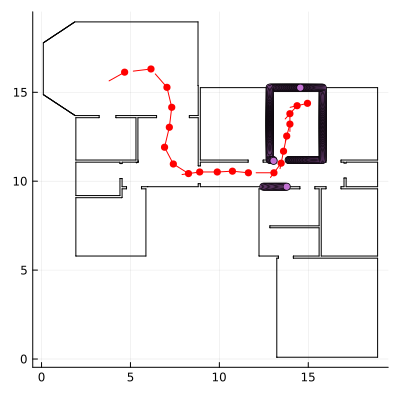

In [294]:
z = Array(minimum(z_, dims=2))[:,1,:];

t = 4
ys = stack([_ps[t].x] .+ polar_inv(z[t,:], _as .+ _ps[t].hd))
# # ---------------------------------------
myplot = plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(_ps[1:20])
scatter!(ys[:,1], ys[:,2])
myplot

## Examples

In [44]:
using Geometry
include("src/unpack_data.jl")

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


glimpse_at_data (generic function with 2 methods)

In [235]:
Base.Vector(p::Pose) = [p.x;p.hd]

In [244]:
p_    = CuArray(stack(Vector.(_ps[1:20])))
segs_ = CuArray(stack(Vector.(_segs)))
z_    = CuArray(Inf*ones(size(p_,1),length(_as)));

n = size(segs_,1)
m = size(p_,1)

datadims = (n,m) 
blockdims = (256,1)
griddims = cuda_grid(datadims, blockdims)

println("Data dim: |env| = $(size(segs)), |a| = $(size(a))")
println("Threads per Block: $(prod(blockdims))")
println("Block dim: $(blockdims)")
println("Grid  dim: $(griddims)")
println()

@cuda threads=blockdims blocks=griddims cast_v3!(segs_, p_, z_);

Data dim: |env| = (427, 4), |a| = (360,)
Threads per Block: 256
Block dim: (256, 1)
Grid  dim: (2, 20)



In [245]:
z = Array(z_)

20×360 Matrix{Float64}:
 0.876518  0.880197  0.884178  0.888466  …  0.867232  0.870041  0.873134
 1.36554   1.34463   1.32474   1.30582      1.43511   1.41071   1.38755
 1.46405   1.46427   1.46494   1.46606      1.46606   1.46494   1.46427
 2.11937   2.10987   2.1011    2.09303      2.15236   2.1406    2.12961
 2.78103   2.77127   2.76242   2.75446      2.81592   2.80334   2.79172
 3.64536   3.63323   3.62229   3.6125    …  3.68903   3.67324   3.65869
 4.09321   4.19139   4.29572   4.40676      3.83112   3.91349   4.00073
 5.83007   5.83096   5.83363   5.83807      5.83807   5.83363   5.83096
 5.40384   5.39525   5.38832   7.27516      5.26778   5.42608   5.41412
 8.17642   7.24774   6.12856   4.84189      8.16512   8.16639   8.17016
 9.01831   9.01968   9.02381   9.03069   …  7.25826   9.02381   9.01968
 3.9039    3.61198   3.62269   3.88937      6.17435   5.17009   5.03515
 1.38222   1.42172   1.46401   1.50936      1.27806   1.3106    1.34525
 1.44153   1.45505   1.46928   1.48425 

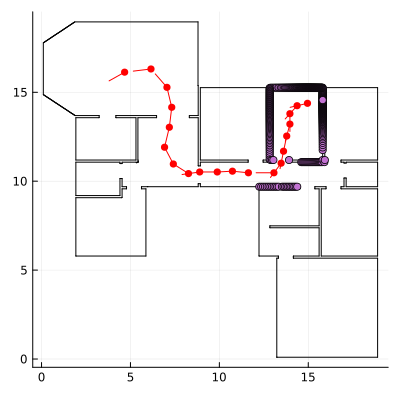

In [246]:
a = collect(range(0,2π,361)[1:end-1])
t=1
ys = stack([_ps[t].x] .+ polar_inv(z[t,:], _as .+ _ps[t].hd))
# # ---------------------------------------
myplot = plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(_ps[1:20])
scatter!(ys[:,1], ys[:,2])
myplot

## Gen - sensor model

In [15]:
using Gen

In [16]:
t = 20

segs = stack(_segs)
a    = _a[1:end]
p    = [_xs[t];_hds[t]]
z    = ones(length(a))*_zmax;

segs_ = CuArray(segs)
a_    = CuArray(a)
z_    = CuArray(z)
p_    = CuArray(p);

size(segs), size(a)

((427, 4), (361,))

In [17]:
@gen function sensor_model(x, hd, std)
        K = length(a_)
    
        z_ = CuArray(ones(K)*_zmax)
        p_ = CuArray([x;hd])
    
        n = length(segs_)
        m = length(a_)
        blockdims = (32,8)
        griddims = cuda_grid((n,m), blockdims)
        CUDA.@sync begin
            @cuda threads=blockdims blocks=griddims cast!(segs_,a_,p_,z_)
        end
        z ~ broadcasted_normal(Array(z_), std*ones(K))
end;

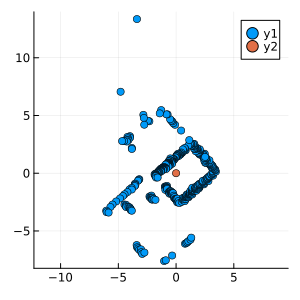

In [18]:
t   = 5
std = 0.1

z  = sensor_model(_xs[t],_hds[t], std);
ys = stack(polar_inv(z, a .+ p[3]))
# ---------------------------------------
plot(size=(300,300), aspect_ratio=:equal)
scatter!(ys[:,1], ys[:,2])
scatter!([0],[0])

In [19]:
args = (_xs[t],_hds[t], std);
ch   = choicemap(:z => _zs[t]);
@btime simulate($sensor_model, $args )     samples=1 evals=1;
@btime generate($sensor_model, $args, $ch) samples=1 evals=1;

  88.963 μs (81 allocations: 40.45 KiB)
  88.399 μs (83 allocations: 34.56 KiB)


```julia
88.985 μs (81 allocations: 40.45 KiB)
87.488 μs (83 allocations: 34.56 KiB)
```